# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;

%matplotlib inline

from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF, \
    StringIndexer, VectorAssembler, Normalizer, StandardScaler
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

In [2]:
# Set up spark session (master node is on local machine).
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Next steps: Loading and cleaning the dataset and checking for invalid or missing data. 

In [3]:
# Read the sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)

In [4]:
# Show number of rows and columns
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
# Show schema of dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Take a look at the columns in the dataset
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,286500,None,None,Cancelled,Logged Out
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,286500,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


In [7]:
# Create a new table for the cleaning of the dataset
df.createOrReplaceTempView('data_tbl')

In [8]:
# Show missing user IDs
spark.sql("SELECT COUNT(userId) FROM data_tbl\
              WHERE userId IS NULL").show()

+-------------+
|count(userId)|
+-------------+
|            0|
+-------------+



In [9]:
# Show empty user IDs
spark.sql("SELECT COUNT(userId) FROM data_tbl\
            WHERE userId == ''").show()

+-------------+
|count(userId)|
+-------------+
|         8346|
+-------------+



In [10]:
# Show missing or empty session IDs
spark.sql("SELECT COUNT(userId) FROM data_tbl\
            WHERE sessionId == '' OR sessionId IS NULL").show()

+-------------+
|count(userId)|
+-------------+
|            0|
+-------------+



In [11]:
# Remove empty user IDs from dataset
data = spark.sql("SELECT * FROM data_tbl\
            WHERE userId != ''")

In [12]:
# Update the table
df.createOrReplaceTempView('data_tbl')

# Exploratory Data Analysis
Get a better understanding of the data. To provide a formal definition of churn, I start with the investigation of the ‘page’ column:

In [13]:
# Take a look at the 'page' column
spark.sql("SELECT page,COUNT(UserId) FROM data_tbl GROUP BY page").toPandas()

,page,count(UserId)
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,14457
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,924


### Define churn
After the first analysis, I will create a column 'Churn' to use as the label for my model. I will use the 'Cancellation Confirmation' events to define my churn, which happens for both paid and free users. Additionally, I will look into the 'Submit Downgrade' events.

In [14]:
# Flag users who have visited the ‘Cancel Confirmation’ page

df = spark.sql("SELECT *,CASE WHEN page == 'Cancellation Confirmation' THEN 1\
            ELSE 0 END AS hasVisitCancel FROM data_tbl")

df.createOrReplaceTempView('data_tbl')

In [15]:
churned_users = spark.sql("SELECT DISTINCT userID FROM data_tbl\
              WHERE hasVisitCancel = 1").toPandas().values

In [16]:
churned_users = [item[0] for item in churned_users]

In [17]:
# Show some examples of churned users
churned_users[0:5]

['125', '51', '54', '100014', '101']

In [18]:
# Define the column 'churn' by flagging all churned users with a 1 and 0 otherwise
has_churned = lambda user: 1 if user in churned_users else 0
spark.udf.register('has_churned', has_churned)

<function __main__.<lambda>(user)>

In [19]:
df = spark.sql("SELECT *,has_churned(userId) as churn FROM data_tbl")

df.createOrReplaceTempView('data_tbl')

In [20]:
# Check number of churned and non-churned users
spark.sql("SELECT churn,count(distinct userId) FROM data_tbl GROUP BY churn").show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    0|                   174|
|    1|                    52|
+-----+----------------------+



In [21]:
# Show number of unique users
spark.sql('SELECT COUNT(DISTINCT userId) AS count_of_Uniq_users  FROM data_tbl').show()

+-------------------+
|count_of_Uniq_users|
+-------------------+
|                226|
+-------------------+



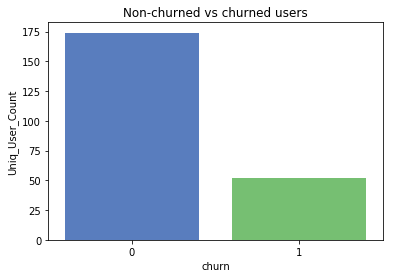

In [22]:
# Visualize the number of non-churned and churned users
df_vs_class=spark.sql("select churn,count(distinct(userId)) AS Uniq_User_Count from data_tbl group by churn").toPandas()

plt.title("Non-churned vs churned users")
sns.barplot(x="churn", y="Uniq_User_Count", data=df_vs_class,palette="muted")
plt.show();

In [23]:
# Take a look at users who have visited the 'Submit Downgrade' page
user_with_downgrade = spark.sql("SELECT DISTINCT userId FROM data_tbl WHERE page = 'Submit Downgrade'")
user_with_downgrade = user_with_downgrade.toPandas()['userId'].values

In [24]:
# Define the column 'churn' by flagging all churned users with a 1 and 0 otherwise
has_sub_downgrade = udf(lambda user: 1 if user in user_with_downgrade else 0, IntegerType())
spark.udf.register('has_sub_downgrade', has_sub_downgrade)

<function __main__.<lambda>(user)>

In [25]:
# Check the distribution of churned and non-churned users for the feature 'Submit Downgrage'
df = spark.sql("SELECT *,has_sub_downgrade(userId) AS hasSubDowngrade FROM data_tbl")
df.createOrReplaceTempView('data_tbl')

feature_downgrade = spark.sql("SELECT DISTINCT userId,hasSubDowngrade,churn FROM data_tbl")
feature_downgrade.createOrReplaceTempView('feature_downgrade_tbl')

spark.sql("SELECT churn, sum(hasSubDowngrade)/count(distinct userId) FROM feature_downgrade_tbl GROUP BY churn").show()

+-----+-----------------------------------------------------------------------------------------------+
|churn|(CAST(sum(CAST(hasSubDowngrade AS BIGINT)) AS DOUBLE) / CAST(count(DISTINCT userId) AS DOUBLE))|
+-----+-----------------------------------------------------------------------------------------------+
|    0|                                                                            0.22988505747126436|
|    1|                                                                            0.17307692307692307|
+-----+-----------------------------------------------------------------------------------------------+



There is no big difference in submitting a downgrade for churned and non-churned users. Non-churned users submit downgrades slightly more often. So I will not include the 'Submit Downgrade' indicator as a feature.

## Feature Engineering
Looking for features to provide signals if a user will churn potentially.

### Feature 1 - Usage Time

In [26]:
# Assumption: Churned users have a lower usage time
feature_usage_time = spark.sql("SELECT churn,sum(length)/count(distinct userID) AS usageTime FROM data_tbl\
                        WHERE page = 'NextSong' GROUP BY churn").show();

usage_time = spark.sql("SELECT churn,sum(length)/count(distinct userId) AS usageTime FROM data_tbl\
                        WHERE page = 'NextSong' GROUP BY churn").toPandas();

feature_usage_time = spark.sql("SELECT DISTINCT userId,sum(nvl(length, 0)) AS usageTime FROM data_tbl\
                        WHERE page = 'NextSong' GROUP BY userId");


feature_usage_time.createOrReplaceTempView('feature_usage_time_tbl')

+-----+-----------------+
|churn|        usageTime|
+-----+-----------------+
|    0|276166.9374678033|
|    1|174014.2685513462|
+-----+-----------------+



In [1]:
# Visualize the results
plt.title("Feature usage time vs target churn");
sns.barplot(x="churn", y="usageTime", data=usage_time,palette="muted");
plt.show();

NameError: name 'plt' is not defined

### Feature 2 - Number of added Friends

In [28]:
# Assumption: Non-churned users add friends more frequently

spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS friends FROM data_tbl\
            WHERE page = 'Add Friend' GROUP BY churn").show();

friends=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS friends FROM data_tbl\
            WHERE page = 'Add Friend' GROUP BY churn").toPandas();

feature_add_friends = spark.sql("SELECT DISTINCT userId,count(1) as friends FROM data_tbl\
            WHERE page = 'Add Friend' GROUP BY userId")

feature_add_friends.createOrReplaceTempView('feature_add_friends_tbl')

+-----+------------------+
|churn|           friends|
+-----+------------------+
|    0| 22.47530864197531|
|    1|14.454545454545455|
+-----+------------------+



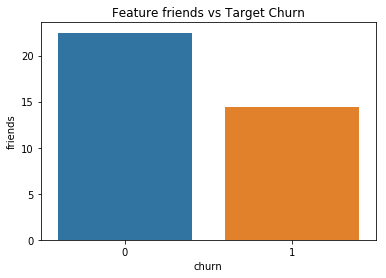

In [62]:
# Visualize the results
plt.title("Feature friends vs target churn");
sns.barplot(x="churn", y="friends", data=friends);
plt.show();

### Feature 3 - Request help

In [30]:
# Assumption: Non-churned users contact the help more frequently
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS help_ FROM data_tbl\
            WHERE page = 'Help' GROUP BY churn").show();

help_1 = spark.sql("SELECT churn,count(1)/count(DISTINCT userID) AS help_ FROM data_tbl\
            WHERE page = 'Help' GROUP BY churn").toPandas();

feature_help = spark.sql("SELECT DISTINCT userId,count(1)/count(DISTINCT userID) AS help_ FROM data_tbl\
            WHERE page = 'Help' GROUP BY userId");


feature_help.createOrReplaceTempView('feature_help_tbl')

+-----+-----------------+
|churn|            help_|
+-----+-----------------+
|    0|9.913333333333334|
|    1|5.558139534883721|
+-----+-----------------+



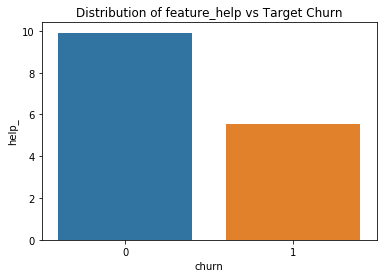

In [31]:
# Visualize the results
plt.title("Feature help vs target churn");
sns.barplot(x="churn", y="help_", data=help_1);
plt.show();

### Feature 4 - Playlists

In [32]:
# Assumption: Churned users have fewer playlists
spark.sql("SELECT churn,count(1)/count(DISTINCT userId)  AS Playlist FROM data_tbl\
                        WHERE page ='Add to Playlist' GROUP BY churn").show();

playlist=spark.sql("SELECT churn,count(1)/count(DISTINCT userId)  AS Playlist FROM data_tbl\
                        WHERE page ='Add to Playlist' GROUP BY churn").toPandas();

feature_Playlist=spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS Playlist FROM data_tbl\
            WHERE page ='Add to Playlist' GROUP BY userId");

feature_Playlist.createOrReplaceTempView('feature_Playlist_tbl');

+-----+-----------------+
|churn|         Playlist|
+-----+-----------------+
|    0|33.26060606060606|
|    1|            20.76|
+-----+-----------------+



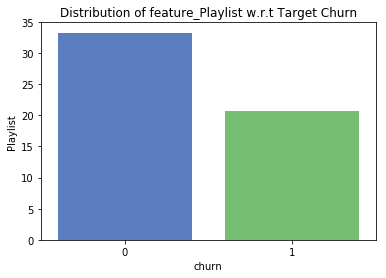

In [33]:
# Visualize the results
plt.title("Feature playlist vs target churn");
sns.barplot(x="churn", y="Playlist", data=playlist,palette="muted");
plt.show();

### Feature 5 - Length Paid User

In [34]:
# Assumption: The time of using payed services is longer for non-churned users
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS lengthAsPaid FROM data_tbl\
            WHERE level = 'paid' GROUP BY churn").show();

length_paid=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS lengthAsPaid FROM data_tbl\
            WHERE level = 'paid' GROUP BY churn").toPandas();

feature_length_paid=spark.sql("SELECT DISTINCT userId,sum(nvl(length, 0)) AS lengthAsPaid FROM data_tbl\
            WHERE level = 'paid' GROUP BY userId");


feature_length_paid.createOrReplaceTempView('feature_length_paid_tbl')

+-----+------------------+
|churn|      lengthAsPaid|
+-----+------------------+
|    0|1505.2769230769231|
|    1| 902.1111111111111|
+-----+------------------+



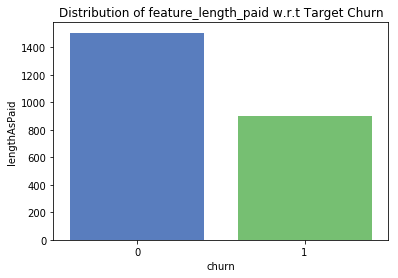

In [35]:
# Visualize the results
plt.title("Feature length paid vs target churn");
sns.barplot(x="churn", y="lengthAsPaid", data=length_paid,palette="muted");
plt.show();

### Feature 6 - Length Free User

In [36]:
# Assumption: Churned users have used free services less time

spark.sql("SELECT churn,count(1)/count(DISTINCT userID) AS lengthAsFree FROM data_tbl\
            WHERE level = 'free' GROUP BY churn").show();

length_free=spark.sql("SELECT churn,count(1)/count(DISTINCT userID) AS lengthAsFree FROM data_tbl\
            WHERE level = 'free' GROUP BY churn").toPandas();

feature_length_free=spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS lengthAsFree FROM data_tbl\
            WHERE level = 'free' GROUP BY userId");


feature_length_free.createOrReplaceTempView('feature_length_free_tbl')

+-----+------------------+
|churn|      lengthAsFree|
+-----+------------------+
|    0| 306.3333333333333|
|    1|269.30434782608694|
+-----+------------------+



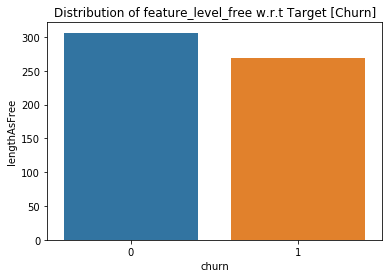

In [37]:
# Visualize the results
plt.title("Feature length free vs target churn");
sns.barplot(x="churn", y="lengthAsFree", data=length_free);
plt.show();

## Create a new table and combine all features

In [38]:
feature_table = spark.sql("SELECT a.userId,b.usageTime,c.friends,d.help_,\
    e.Playlist,f.lengthAsPaid,g.lengthAsFree,a.churn AS label FROM data_tbl AS a\
    LEFT OUTER JOIN feature_usage_time_tbl as b\
    ON a.userId=b.userId \
    LEFT OUTER JOIN feature_add_friends_tbl as c\
    ON b.userId=c.userId \
    LEFT OUTER JOIN feature_help_tbl as d\
    ON c.userId=d.userId \
    LEFT OUTER JOIN feature_Playlist_tbl as e\
    ON d.userId=e.userId \
    LEFT OUTER JOIN feature_length_paid_tbl as f\
    ON e.userId=f.userId \
    LEFT OUTER JOIN feature_length_free_tbl as g\
    ON f.userId=g.userId");

feature_table.createOrReplaceTempView('feature_table')

# Class distribution valid?
spark.sql("select label,count(distinct userId) as Class_dist from feature_table group by label").show()

+-----+----------+
|label|Class_dist|
+-----+----------+
|    0|       174|
|    1|        52|
+-----+----------+



In [39]:
features = spark.sql("""
    SELECT
        nvl(userId,0) as userId,
        nvl(usageTime,0) as usageTime,
        nvl(friends,0) as friends,
        nvl(help_,0) as help_,
        nvl(Playlist,0) as Playlist,
        nvl(lengthAsPaid,0) as lengthAsPaid,
        nvl(lengthAsFree,0) as lengthAsFree
    FROM
        feature_table
    """)

features.createOrReplaceTempView('feature_table')

In [40]:
# Include the target label
targets = spark.sql("SELECT DISTINCT userId,churn as label FROM data_tbl")

targets.createOrReplaceTempView('targets_tbl')

In [41]:
features = spark.sql("SELECT f.*,CAST(t.label AS INT) AS label FROM feature_table as f,targets_tbl as t\
            WHERE f.userId=t.userId")

features.createOrReplaceTempView('feature_table')

## Machine Learning to Predict Churn
Train a binary classifier to predict churn. Different models are being used.

In [42]:
# Vectorize and scale the features
assembler = VectorAssembler(inputCols=["lengthAsFree", "lengthAsPaid", "help_", "friends", "usageTime", 'Playlist'], outputCol="AllFeatures")
scaler = Normalizer(inputCol="AllFeatures", outputCol="ScaledAllFeatures")

In [43]:
# Create two different models and wrap them in a pipeline object
model_lr = LogisticRegression(featuresCol="ScaledAllFeatures", labelCol="label", maxIter=20, regParam=0.01)
model_gbt = GBTClassifier(featuresCol="ScaledAllFeatures", labelCol="label")

pipeline_lr = Pipeline(stages=[assembler, scaler, model_lr])
pipeline_gbt = Pipeline(stages=[assembler, scaler, model_gbt])

In [44]:
# Use 80 % of the data for training and 20 % of the data for testing
training, test = features.randomSplit([0.8, 0.2])

In [45]:
# Use the fit method and train the models on the training data
model_lr_fitted = pipeline_lr.fit(training)
model_gbt_fitted = pipeline_gbt.fit(training)

In [46]:
# Define a helper function to evaluate the performance of the models
def model_performance(model, test_data, metric = 'f1'):
    """ Evaluate a machine learning model's performance 
    
        Input: 
            model(object) - trained model or pipeline object
            metric - the metric used to measure performance
            data - test data on which performance measurement should be performed
        Output:
            score
    """
    
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(test_data)
    
    # Calcualte the score
    score = evaluator.evaluate(predictions)
    
    return score

In [47]:
# Performance of the logistic regression model
model_performance(model_lr_fitted, test)

0.7699773732592362

In [48]:
# Performance of the GBT classifier model
model_performance(model_gbt_fitted, test)

0.9951519732209986

The GBT classifier model performs best in terms of the f1-score.

In [49]:
def do_preprocessing(feature_cols, model):
    """Vectorizes and Scales all features
    Input:
        feature_cols(list): name of the feature columns in the Spark Data Frame
        model(object): Spark machine Learning model object 
    Output:
        pipeline(object): Spark Pipeline object
    
    """
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="AllFeatures")
    scaler = Normalizer(inputCol="AllFeatures", outputCol="ScaledAllFeatures")
    pipeline = Pipeline(stages=[assembler, scaler, model])
    
    return pipeline

### Improvements
In this section I will try to improve the model performance as I will include two additional features. I will also try out an additional Machine Learning Model: Random Forest Classifier.

In [50]:
# Feature 7 - Include a new feature: Thumbs up
feature_thumbs_up = spark.sql("SELECT DISTINCT userId,count(1) AS n_ThumbsUp FROM data_tbl\
            WHERE page = 'Thumbs Up' GROUP BY userId")

feature_thumbs_up.createOrReplaceTempView('feature_thumbs_up_tbl')

In [51]:
feature_thumbs_up = spark.sql("SELECT DISTINCT d.userId,nvl(n_ThumbsUp,0) AS n_ThumbsUp FROM data_tbl\
            AS d LEFT JOIN feature_thumbs_up_tbl AS f ON d.userId=f.userId")

In [52]:
# Feature 8 - Include a new feature: Thumbs down
feature_thumbs_down = spark.sql("SELECT DISTINCT userId,count(1) AS n_ThumbsDown FROM data_tbl\
            WHERE page = 'Thumbs Down' GROUP BY userId")

feature_thumbs_down.createOrReplaceTempView('feature_thumbs_down_tbl')

In [53]:
feature_thumbs_down = spark.sql("SELECT DISTINCT d.userId,nvl(n_ThumbsDown,0) AS n_ThumbsDown FROM data_tbl\
            AS d LEFT JOIN feature_thumbs_down_tbl AS f ON d.userId=f.userId")

In [54]:
# Combine the old and new features
features = spark.sql("SELECT f.*,n_ThumbsUp,n_ThumbsDown FROM feature_table\
            AS f,feature_thumbs_down_tbl AS d,feature_thumbs_up_tbl AS u\
            WHERE f.userId = d.userId AND d.userId = u.userId")

In [55]:
# Build new models with the additional features
feature_cols = ["lengthAsFree", "lengthAsPaid", "help_", "friends", "usageTime", "Playlist", "n_ThumbsUp", "n_ThumbsDown"]

In [56]:
# Create three different models and wrap them in a pipeline object
model_lr = LogisticRegression(featuresCol="ScaledAllFeatures", labelCol="label", maxIter=20, regParam=0.01)
model_gbt = GBTClassifier(featuresCol="ScaledAllFeatures", labelCol="label")
model_rf = RandomForestClassifier(featuresCol="ScaledAllFeatures", labelCol="label")

pipeline_lr = do_preprocessing(feature_cols, model_lr)
pipeline_gbt = do_preprocessing(feature_cols, model_gbt)
pipeline_rf = do_preprocessing(feature_cols, model_rf)

In [57]:
# Use 80 % of the data for training and 20 % of the data for testing
training, test = features.randomSplit([0.8, 0.2])

In [58]:
# Use the fit method and train the models on the training data
model_fitted_lr = pipeline_lr.fit(training)
model_fitted_gbt = pipeline_gbt.fit(training)
model_fitted_rf = pipeline_rf.fit(training)

In [59]:
# Performance of the logistic regression model
model_performance(model_fitted_lr, test)

0.7767079400719782

In [60]:
# Performance of the GBT classifier
model_performance(model_fitted_gbt, test)

0.9957086918191329

In [61]:
# Performance of the ramdon forrest classifier
model_performance(model_fitted_rf, test)

0.9248557896618619

Result: The newly introduced Random Forest Classifier with the additional features performs best.